# 1.0 Data Preparations

In [1]:
import numpy as np 
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Read the data
X = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
X_test_full = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

### Encoding
##### Label and One-Hot Encoding

In [2]:
# Label encoding for object columns with 2 or less unique values

le = LabelEncoder()
le_count = 0

for col in X:
    if X[col].dtype == 'object':
        if len(list(X[col].unique())) <= 2:
            le.fit(X[col])
            X[col] = le.transform(X[col])
            X_test_full[col] = le.transform(X_test_full[col])
            
# One-Hot encoding for object columns with more than 2 unique values

X = pd.get_dummies(X)
X_test_full = pd.get_dummies(X_test_full)

# Align training and testing data
train_labels = X['TARGET']
X, X_test_full = X.align(X_test_full, join = 'left', axis=1)
X['TARGET'] = train_labels

# Data Analysis

### Anomalies

In [3]:
# DAY_BIRTH column
(X['DAYS_BIRTH']/-365).describe()

# Result: Seems normal

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [4]:
# DAYS_EMPLOYED column
X['DAYS_EMPLOYED'].describe()

# Result: There must be an outlier for the max value

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

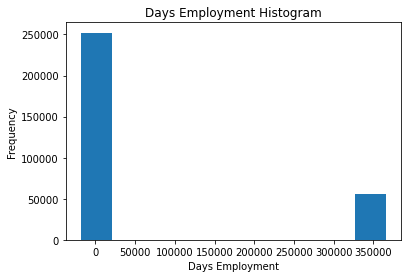

In [5]:
X['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

To handle the anomalies values, we have to set the anomalies to a missing value
and then we will create a new boolean column to indicate that the values was anomalous

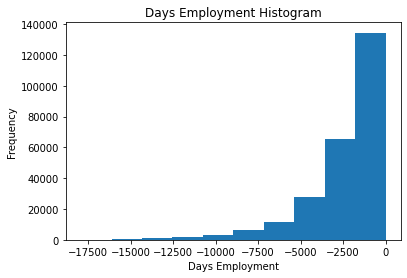

In [6]:
# Create anomalous indicator boolean column
X['DAYS_EMPLOYED_ANOM'] = X['DAYS_EMPLOYED'] == 365243
X_test_full['DAYS_EMPLOYED_ANOM'] = X_test_full['DAYS_EMPLOYED'] == 365243

# Replace anomalous values with nan
X['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
X_test_full['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

X['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [7]:
(X['DAYS_REGISTRATION']/365).describe()

count    307511.000000
mean        -13.660604
std           9.651743
min         -67.594521
25%         -20.491781
50%         -12.339726
75%          -5.506849
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [8]:
(X['DAYS_ID_PUBLISH']/365).describe()

count    307511.000000
mean         -8.203294
std           4.135481
min         -19.717808
25%         -11.778082
50%          -8.915068
75%          -4.712329
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

For rest of the columns that is correlated with 'DAYS', the 
values seems normal

### Correlations

In [9]:
# Find correlations with the target
corr = X.corr()['TARGET'].sort_values()

print('Most positive correlations\n', corr.tail(15))
print('Most negative correlations\n', corr.head(15))

Most positive correlations
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
Most negative

### Effect of Age on Loan Repayment

DAYS_BIRTH is positively correlated, but the values are negative
Which means that the older the applicant, more likely that the applicant
would be able to pay their loan

To make things clearer, we make DAYS_BIRTH column values to positive

In [10]:
X['DAYS_BIRTH'] = abs(X['DAYS_BIRTH'])
X_test_full['DAYS_BIRTH'] = abs(X_test_full['DAYS_BIRTH'])

X['DAYS_BIRTH'].corr(X['TARGET'])

-0.07823930830982694

We will try to create KDE plot to show the distribution of ages

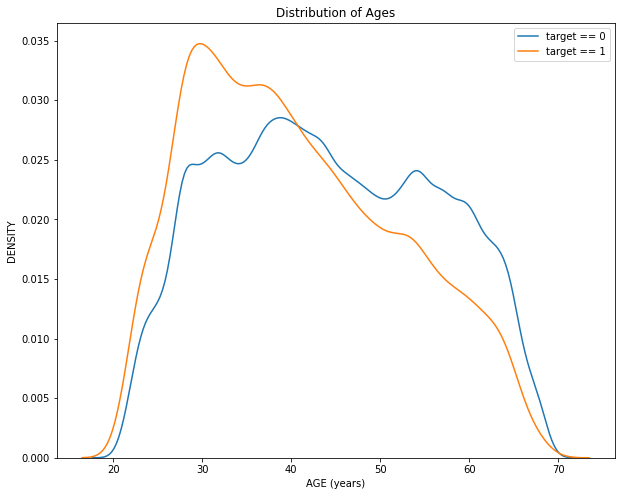

In [11]:
plt.figure(figsize=(10, 8))

# Plot X['DAYS_BIRTH'] where X['TARGET'] == 0
sns.kdeplot(X.loc[X['TARGET']==0, 'DAYS_BIRTH']/365, label = 'target == 0')
# Plot X['DAYS_BIRTH'] where X['TARGET'] == 1
sns.kdeplot(X.loc[X['TARGET']==1, 'DAYS_BIRTH']/365, label = 'target == 1')

plt.xlabel('AGE (years)'); plt.ylabel('DENSITY'); plt.title('Distribution of Ages');
plt.legend()

Next, we'll try to group applicant ages, and for each group we count
the average value of the target

In [12]:
age_data = X[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [13]:
# Group by bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


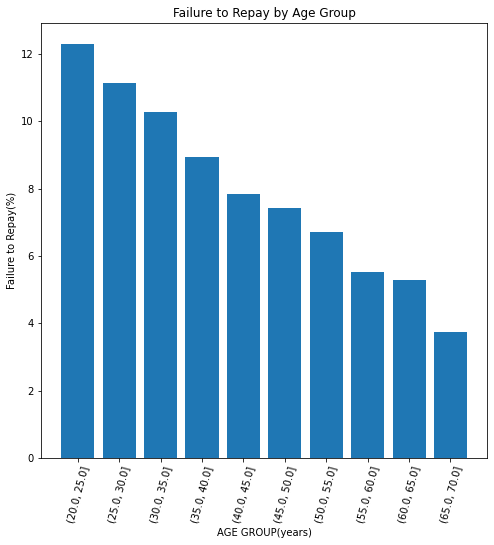

In [14]:
plt.figure(figsize=(8, 8))

plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])

plt.xticks(rotation=75); plt.xlabel('AGE GROUP(years)'); plt.ylabel('Failure to Repay(%)');
plt.title('Failure to Repay by Age Group');

Younger applicants are more likely to not repay loan. Maybe Home Credit should
educate younger applicants with guidance and financial planning tips

### Exterior Sources

In [15]:
# Extract EXT_SOURCE features with the target and each others
ext_data = X[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corr = ext_data.corr()
ext_data_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


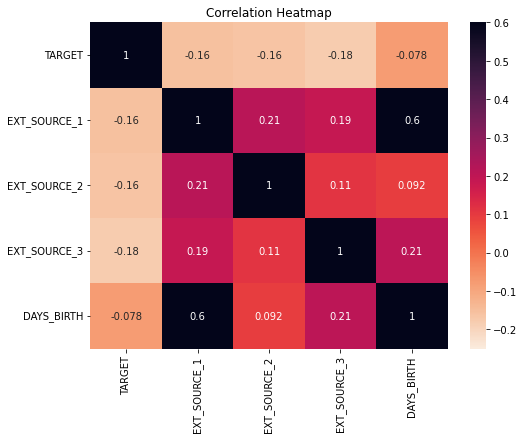

In [16]:
plt.figure(figsize=(8, 6))

sns.heatmap(ext_data_corr, cmap='rocket_r', vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

All External sources have negative correlation with TARGET. Which means that the higher the External Source value, more likely applicant will repay the loan.

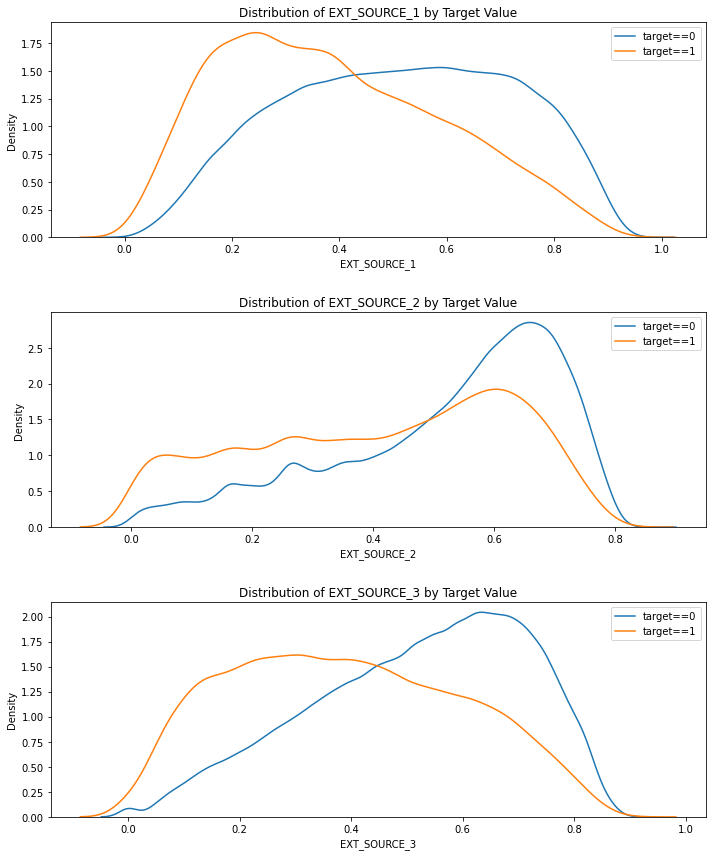

In [17]:
plt.figure(figsize=(10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # new subplot for each external source
    plt.subplot(3, 1, i+1)
    # plot repaid loans
    sns.kdeplot(X.loc[X['TARGET']==0, source], label='target==0')
    sns.kdeplot(X.loc[X['TARGET']==1, source], label='target==1')
    # labeling the plot
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad=2.7)

EXT_SOURCE_3 display the greatest difference between target==0 and target==1. So, this feature has a relationship to the likelihood of an applicant paying back loan. 

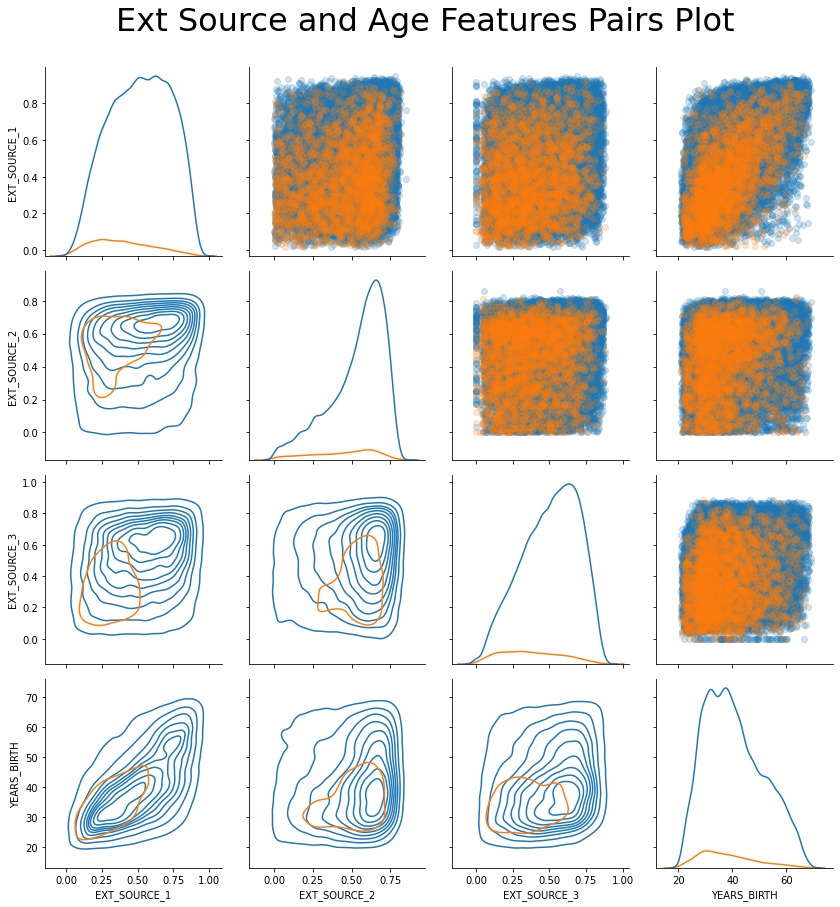

In [18]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Feature Engineering

### Polynomial Features

In [19]:
import sklearn
print(sklearn.__version__)

1.0.2


In [20]:
# Make new dataframe for polynomial features
poly_features = X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = X_test_full[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Imputer to handle missing values 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

# Impute the missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

# Create polynomial object with specified degrees
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


We'll get the names of new features using get_feature_names method

In [21]:
poly_features_names = poly_transformer.get_feature_names(input_features = 
                                                         ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                                                          'DAYS_BIRTH'])
print("There are {} polynomial features".format(len(poly_features_names)))
print(poly_features_names)


There are 35 polynomial features
['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_3^2', 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_1 DAYS_BIRTH^2', 'EXT_SOURCE_2^3', 'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH', 'EXT_SOURCE_2 EXT_SOURCE_3^2', 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH', 'EXT_SOURCE_2 DAYS_BIRTH^2', 'EXT_SOURCE_3^3', 'EXT_SOURCE_3^2 DAYS_BIRTH', 'EXT_SOURCE_3 DAYS_BIRTH^2', 'DAYS_BIRTH^3']


Now we'll see if these new features are correlated with the target

In [22]:
# Create new dataframe of the features
poly_features = pd.DataFrame(poly_features,
                            columns = poly_features_names)

# Add in the target
poly_features['TARGET'] = poly_target

# Find correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most positive and negative correlations
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


We don't know if these polynomial features help improves the model, so we'll just try it out.

In [23]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                 columns = poly_features_names)

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = X['SK_ID_CURR']
X_train_poly = X.merge(poly_features, on = 'SK_ID_CURR', how='left')

# Merge polynomial features into test dataframe
poly_features_test['SK_ID_CURR'] = X_test_full['SK_ID_CURR']
X_test_poly = X_test_full.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
X_train_poly, X_test_poly = X_train_poly.align(X_test_poly, join='inner', axis=1)

# Print out the new shapes
print('Training data with polynomial features shape: ', X_train_poly.shape)
print('Testing data with polynomial features shape:  ', X_test_poly.shape)

Training data with polynomial features shape:  (307511, 278)
Testing data with polynomial features shape:   (48744, 278)


# Baseline

For a naive baseline, we could guess 0.5 for all observations on the test set. This will get us AUC ROC of 0.5 on the competition. Since we already know the score, we don't need to make naive baseline guess.

### Logistic Regression

In [24]:
from sklearn.preprocessing import MinMaxScaler

train = X.drop(columns = ['TARGET'])
    
# Feature names
features = list(train.columns)

# Copy of test dataset
test = X_test_full.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Align the dataframes
train, test = train.align(test, join='inner', axis=1)

# Transform both training and test data
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 243)
Testing data shape:  (48744, 243)


In [25]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

In [26]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [27]:
# Submission dataframe
submit = X_test_full[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

,SK_ID_CURR,TARGET
0,100001,0.065383
1,100005,0.117354
2,100013,0.067974
3,100028,0.070889
4,100038,0.117988


In [28]:
# Save the submission to csv
submit.to_csv('log_reg_baseline.csv', index = False)

### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

In [30]:
# Train the training data
random_forest.fit(train, train_labels)

# Make predictions one the test data
preds = random_forest.predict_proba(test)[:, 1]

In [31]:
submit = X_test_full[['SK_ID_CURR']]
submit['TARGET'] = preds

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

### Make predictions using engineered features

##### Testing polynomial features

In [32]:
# Impute polynomial features
imputer = SimpleImputer(strategy='median')
poly_features = imputer.fit_transform(X_train_poly)
poly_features_test = imputer.transform(X_test_poly)

# Scale polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))
poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=0)

In [33]:
# Train the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
preds = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [34]:
# Make submission dataframe
submit = X_test_full[['SK_ID_CURR']]
submit['TARGET'] = preds

# Save the submission dataframe
submit.to_csv('random_forest_poly.csv', index=False)

##### Testing domain features